# Sewer network example

This example demonstrates the use of pysewer to generate a sewer network using the the following data inputs:
- A digital elevation model (DEM)
- Road network data
- Building footprint data

In this example the road and building data are generated using the [OSMnx] package.

The network is generated using the following steps:
1. Preprocessing of the input data. This involves setting input parameters and converting the input data to the correct format. This is then followed by instantiation of the network using pysewer.ModelDomain
2. Application of the routing algorithm to generate the sewer network. This is done using repeated shortest path heuristic (RSPH) algorithm. This is done using pysewer.rsph_tree ()
3. Hydraulic calculations and pump optimization 
4. Post processing of the results
5. Export of the generated sewer network to a geopackage file using the pysewer.export module. Shapefiles and geoparquet files are also supported.

## Preprocessing


In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import pysewer
import matplotlib.pyplot as plt
import networkx as nx
from pysewer.config.settings import load_config, config_to_dataframe, view_default_settings  # load the the settings file 

load_dotenv()
WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')

# get the currene working directory
CWD = Path.cwd()
if CWD != WORKSPACE_DIR:
    os.chdir(WORKSPACE_DIR)
    print(f'Changed working directory to {WORKSPACE_DIR}')

Changed working directory to /Users/despot/Nextcloud/Cloud/Python_Projects/pysewer_dev


In [2]:
from matplotlib.dates import DateFormatter
# set matplotlib setting 
myfmt = DateFormatter("%m.%y")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [
    "Arial",
    "Tahoma",
    "DejaVu Sans",
    "Lucida Grande",
    "Verdana",
]
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 13
plt.rcParams["figure.titlesize"] = 12

plt.rcParams["xtick.major.pad"] = 5  # distance to major tick label in points

### View default parameters 
Here one can view the default settings 

In [3]:
 # here you can see that the input data is missing. You can either create a config file to add them or add them manually.
view_default_settings()

,Setting,Value
0,preprocessing_dem_file_path,None
1,preprocessing_roads_input_data,None
2,preprocessing_buildings_input_data,None
3,preprocessing_dx,10
4,preprocessing_pump_penalty,1000
5,preprocessing_max_connection_length,30
6,preprocessing_clustering,centers
7,preprocessing_connect_buildings,True
8,preprocessing_add_private_sewer,True
9,preprocessing_field_get_sinks,node_type


### Load custom settings 
The customs settings are stored in yaml file within the notebook. The settings are loaded using the pysewer.config.settings.load_config function. This created a Config class from which settings are then passed to the pysewer.ModelDomain class to initialise the model domain.

Note the defaults settings are stored within the pysewer package. These can be viewed using the pysewer.config.settings.view_default_settings function.

The settings file is dived into 4 sections:
1. the preprocessing parameters settings
2. the optimization parameter settings. Use for carrying out the hydraulic calculations and pump optimization
3. the plot settings
4. the export settings

To change the settings, the user can either edit the yaml file or change the settings directly using the Config class. For example, to change the minimum trench depth of the sewer pipes to 1 m in the example_settings.yaml file, the user can change the following line:

```yaml
optimization:
  min_trench_depth: 0.5
```

Finally, one can display the final settings that would be used to initalise the mode.

In [4]:
# load custom settings from the example settings file
custom_config = load_config("./combined_sewer_dev/industry_setting.yaml")
df_config = config_to_dataframe(custom_config)
display(df_config)

,Setting,Value
0,preprocessing_dem_file_path,/Users/despot/Nextcloud/Cloud/Projects/Waterun...
1,preprocessing_roads_input_data,/Users/despot/Nextcloud/Cloud/Projects/Waterun...
2,preprocessing_buildings_input_data,/Users/despot/Nextcloud/Cloud/Projects/Waterun...
3,preprocessing_dx,10
4,preprocessing_pump_penalty,1000
5,preprocessing_max_connection_length,30
6,preprocessing_clustering,none
7,preprocessing_connect_buildings,True
8,preprocessing_add_private_sewer,True
9,preprocessing_field_get_sinks,node_type


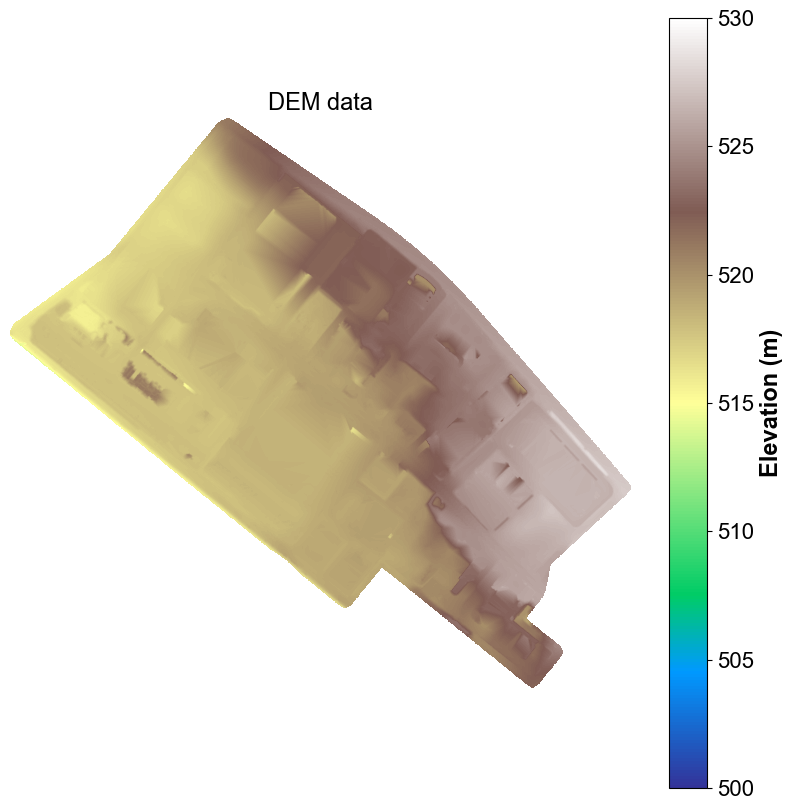

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
 # let's do a manaual preporcessing of the DEM, roads and building data
# load the DEM data
dem = "./data/combined_sewer/industry_dem_1.tif"
# inspect the DEM data using rasterio
with rasterio.open(dem) as src:
    dem_data = src.read(1)
    dem_meta = src.meta
    dem_crs = src.crs
    dem_bounds = src.bounds
    dem_transform = src.transform
    dem_nodata = src.nodata
    dem_res = src.res
    dem_profile = src.profile

# drop the nodata value
dem_data = dem_data.astype(float)
dem_data[dem_data == dem_nodata] = np.nan


# plot the DEM data, plot the DEM data above 0m
dem_data[dem_data < 0] = 0
plt.figure(figsize=(10, 10))
plt.imshow(dem_data, cmap="terrain")
# modify the colorbar range
plt.clim(500, 530)
plt.colorbar(label="Elevation (m)")
plt.title("DEM data")
plt.axis("off")
plt.show()



In [6]:
from pysewer.preprocessing import DEM
dem_processor = DEM(dem)
dem_processor.get_crs  # property to get the crs of the DEM data


CRS.from_epsg(2056)

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


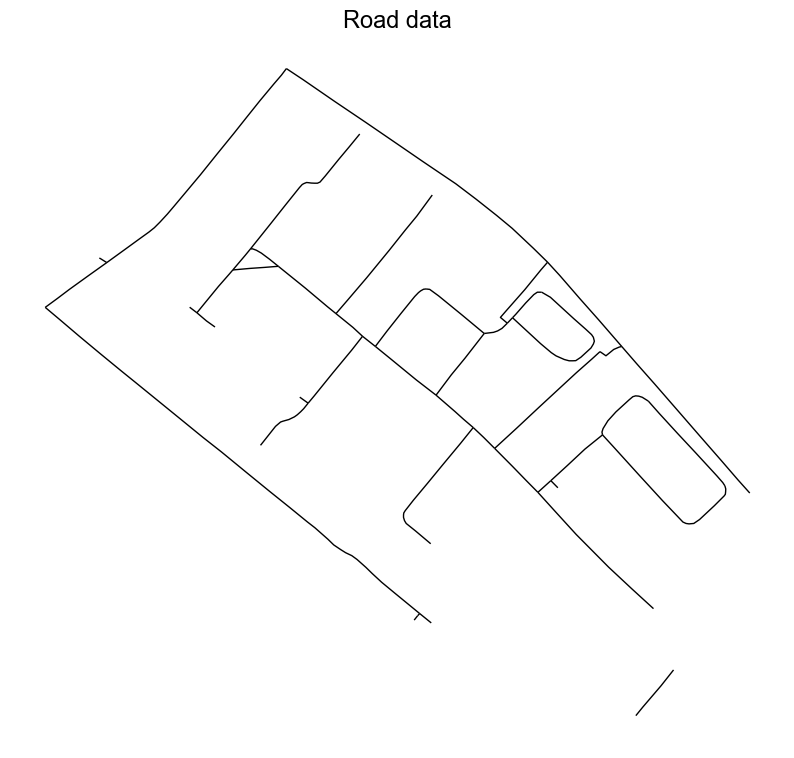

In [7]:
# load the road data
roads_path = custom_config.preprocessing.roads_input_data
roads = gpd.read_file(roads_path)

roads.crs  # check the crs of the road data

# plot the road data
plt.figure(figsize=(10, 10))
roads.plot(ax=plt.gca(), color="black", linewidth=1)
plt.title("Road data")
plt.axis("off")
plt.show()


In [8]:
# inspect the road gdf 
roads.head()

,OBJECTID,UUID,DATUM_AENDERUNG,DATUM_ERSTELLUNG,ERSTELLUNG_JAHR,ERSTELLUNG_MONAT,REVISION_JAHR,REVISION_MONAT,GRUND_AENDERUNG,HERKUNFT,...,RICHTUNGSGETRENNT,BELAGSART,KREISEL,EIGENTUEMER,VERKEHRSBEDEUTUNG,NAME,TLM_STRASSEN_NAME_UUID,Shape_Length,id,geometry
0,24,{89D664DE-AF62-4C17-9452-5E6A063912AF},2011-12-09T06:34:25+00:00,2011-12-09T06:34:18+00:00,2010,6.0,2013,6,400,100,...,1,100,1,999997,999998,None,None,195.151025,None,None
1,62,{81E74D32-25E0-4C1B-860E-719A7A8DD45D},2011-12-09T13:21:25+00:00,2011-12-09T06:42:06+00:00,2010,6.0,2013,6,400,100,...,1,100,1,999997,999998,None,None,63.199137,None,MULTILINESTRING Z ((2698287.914 1250037.652 52...
2,63,{47B30F55-2E6E-4A90-BBCC-C1A821B71F02},2011-12-09T13:21:25+00:00,2007-09-20T00:00:00+00:00,2002,NaN,2013,6,400,100,...,1,100,1,999997,999998,None,None,170.458870,None,MULTILINESTRING Z ((2698402.875 1249989.764 52...
3,73,{BB98288C-BAD5-4C76-8AA4-896BF30CED43},2016-02-11T09:40:51+00:00,2011-12-09T06:49:00+00:00,2010,6.0,2013,6,400,100,...,1,100,1,999997,999998,None,None,31.407372,None,MULTILINESTRING Z ((2697983.381 1250195.997 51...
4,91,{D8B5C7AF-322B-427A-AF84-659A94D3F246},2013-10-07T14:55:55+00:00,2013-10-07T14:55:55+00:00,2013,6.0,2013,6,300,100,...,1,100,1,999997,999998,None,None,105.426861,None,MULTILINESTRING Z ((2698236.320 1250199.840 52...


In [9]:
# use the road class processor 
from pysewer.preprocessing import Roads
roads_processor = Roads(roads_path)

road_gdf = roads_processor.get_gdf()

road_gdf.head()

,OBJECTID,UUID,DATUM_AENDERUNG,DATUM_ERSTELLUNG,ERSTELLUNG_JAHR,ERSTELLUNG_MONAT,REVISION_JAHR,REVISION_MONAT,GRUND_AENDERUNG,HERKUNFT,...,RICHTUNGSGETRENNT,BELAGSART,KREISEL,EIGENTUEMER,VERKEHRSBEDEUTUNG,NAME,TLM_STRASSEN_NAME_UUID,Shape_Length,id,geometry
1,62,{81E74D32-25E0-4C1B-860E-719A7A8DD45D},2011-12-09T13:21:25+00:00,2011-12-09T06:42:06+00:00,2010,6.0,2013,6,400,100,...,1,100,1,999997,999998,None,None,63.199137,None,"MULTILINESTRING ((2698287.914 1250037.652, 269..."
2,63,{47B30F55-2E6E-4A90-BBCC-C1A821B71F02},2011-12-09T13:21:25+00:00,2007-09-20T00:00:00+00:00,2002,NaN,2013,6,400,100,...,1,100,1,999997,999998,None,None,170.458870,None,"MULTILINESTRING ((2698402.875 1249989.764, 269..."
3,73,{BB98288C-BAD5-4C76-8AA4-896BF30CED43},2016-02-11T09:40:51+00:00,2011-12-09T06:49:00+00:00,2010,6.0,2013,6,400,100,...,1,100,1,999997,999998,None,None,31.407372,None,"MULTILINESTRING ((2697983.381 1250195.997, 269..."
4,91,{D8B5C7AF-322B-427A-AF84-659A94D3F246},2013-10-07T14:55:55+00:00,2013-10-07T14:55:55+00:00,2013,6.0,2013,6,300,100,...,1,100,1,999997,999998,None,None,105.426861,None,"MULTILINESTRING ((2698236.320 1250199.840, 269..."
5,111,{75B1789D-9EF5-4AFC-9905-5F813A0CC08B},2011-12-09T06:50:49+00:00,2011-12-09T06:49:00+00:00,2010,6.0,2013,6,400,100,...,1,100,1,999997,999998,None,None,42.869448,None,"MULTILINESTRING ((2697940.651 1250192.562, 269..."


/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


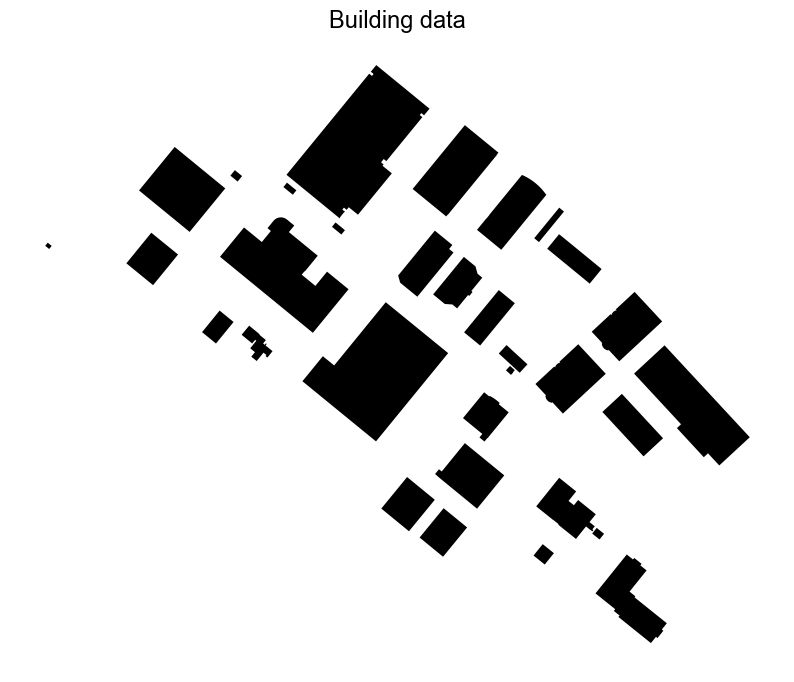

In [10]:
# load the building data
buildings_path = custom_config.preprocessing.buildings_input_data
buildings = gpd.read_file(buildings_path)

buildings.crs  # check the crs of the building data

# plot the building data
plt.figure(figsize=(10, 10))
buildings.plot(ax=plt.gca(), color="black", linewidth=1)
plt.title("Building data")
plt.axis("off")
plt.show()


In [11]:
# use the building class processor
from pysewer.preprocessing import Buildings
buildings_processor = Buildings(buildings_path, roads_obj=roads_processor)
building_gdf = buildings_processor.get_gdf()

building_gdf.head()


/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,OBJECTID,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,...,R1_GUELTI2,R1_DATUM1,Art_Categorie,Art_Typ_de,Art_Typ_en,Shape_Length,Shape_Area,fid_2,id,geometry
0,37,z5bed8746d67a002c,BBNachfuehrung[z5bed8185d67a00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z5bed8185d67a0000,ZH0200000172,993.005,...,20190108,-99,Gebaeude,Gebaeude,buildings,120.591741,897.661197,1,None,POINT (2698126.732 1249901.700)
1,84,z58caa8989bad00ca,BBNachfuehrung[z58ca9dcb9bad00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z58ca9dcb9bad0000,ZH0200000172,987.003,...,20170406,-99,Gebaeude,Gebaeude,buildings,369.481248,7531.145419,1,None,POINT (2698068.846 1250043.637)
2,1438,z50ac8a910000170a,BBNachfuehrung[z50ac8a9100000d,0,AV93,7,Gebaeude.Nebengebaeude,z50ac8a9100000dcf,ZH0200000172,869F,...,20030911,-99,Gebaeude,Gebaeude,buildings,80.587071,188.869873,1,None,POINT (2698220.193 1250173.548)
3,1441,z50ac8a9100001707,BBNachfuehrung[z50ac8a9100000e,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000e1a,ZH0200000172,872F,...,20040510,-99,Gebaeude,Gebaeude,buildings,181.694953,1779.589934,1,None,POINT (2698187.510 1250185.116)
4,1504,z50ac8a91000016c1,BBNachfuehrung[z50ac8a9100000e,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000e6a,ZH0200000172,926F,...,20080926,-99,Gebaeude,Gebaeude,buildings,135.270188,1138.878007,1,None,POINT (2698095.528 1249926.740)


In [12]:
# # check the creattion of the unsimplified graph 

# from shapely import LineString, MultiLineString
# import geopandas as gpd

# def create_unsimplified_graph(roads_gdf: gpd.GeoDataFrame) -> nx.Graph:
#         """
#         Create an unsimplified graph from a GeoDataFrame of roads.
#         Parameters
#         ----------
#         roads_gdf : gpd.GeoDataFrame
#             A GeoDataFrame containing road data.
#         Returns
#         -------
#         nx.Graph
#             An unsimplified graph containing nodes and edges from the GeoDataFrame.
#         """
#         # Initialize an empty undirected graph
#         G_unsimplified = nx.Graph()

#         # validate the the geometry column, so that it contains only Linestring or MultiLineString geometries
#         if not roads_gdf["geometry"].apply(lambda geom: isinstance(geom, (LineString, MultiLineString))).all():
#             raise ValueError("Invalid geometry type. Only LineString or MultiLineString geometries are allowed.")
    
#         # iterate over each row in the GeoDataFrame
#         for index, row in roads_gdf.iterrows():
#             geometry = row["geometry"]
#             road_attrs = row.drop(
#                 "geometry"
#             ).to_dict()  # Convert other attributes to a dictionary

#             # Handle MultiLineString geometries
#             if isinstance(geometry, MultiLineString):
#                 # iterate over each LineString in the lines list 
#                 for line in geometry.geoms:
#                     for i in range(len(line.coords) - 1):
#                         start_point = line.coords[i]
#                         end_point = line.coords[i + 1]

#                         # Create a LineString geometry for the segment
#                         segment_geometry = LineString([start_point, end_point])

#                         # Add edge to the graph, include the segment geometry
#                         G_unsimplified.add_edge(
#                             start_point, end_point, geometry=segment_geometry, **road_attrs
#                         )
#             else:  # Single LineString geometry
#                 for i in range(len(geometry.coords) - 1):
#                     start_point = geometry.coords[i]
#                     end_point = geometry.coords[i + 1]

#                     # Create a LineString geometry for the segment
#                     segment_geometry = LineString([start_point, end_point])

#                     # Add edge to the graph, include the segment geometry
#                     G_unsimplified.add_edge(
#                         start_point, end_point, geometry=segment_geometry, **road_attrs
#                     )

#         return G_unsimplified

# # create the unsimplified graph
# G_unsimplified = create_unsimplified_graph(road_gdf)

# G_unsimplified = nx.Graph(G_unsimplified)

In [13]:
# # plot the unsimplified graph
# plt.figure(figsize=(10, 10))
# nx.draw(G_unsimplified, pos={node: node for node in G_unsimplified.nodes()}, node_size=0, edge_color="black")
# plt.title("Unsimplified graph")
# plt.axis("off")
# plt.show()


In [14]:
# print(f"Number of nodes: {G_unsimplified.number_of_nodes()}")
# print(f"Number of edges: {G_unsimplified.number_of_edges()}")
# print(f"Graph density: {nx.density(G_unsimplified)}")


In [15]:
# sub_graphs = list(
#             (
#                 G_unsimplified.subgraph(c).copy()
#                 for c in nx.connected_components(G_unsimplified)
#             )
#         )

# print(f"Number of connected components: {len(sub_graphs)}")

In [16]:
# import warnings
# from pysewer.helper import get_node_gdf
# from shapely.ops import nearest_points
# def connect_subgraphs(connection_graph: nx.Graph):
#         """Identifies unconnected street subnetworks and connects them based on shortest distance"""
#         G = connection_graph
#         sub_graphs = list((G.subgraph(c).copy() for c in nx.connected_components(G)))
#         while len(sub_graphs) > 1:
#             # select one subgraph
#             sg = sub_graphs.pop()
#             G_without_sg = sub_graphs.pop()

#             while len(sub_graphs) > 0:
#                 G_without_sg = nx.compose(G_without_sg, sub_graphs.pop())

#             # get shortest edge between sg and G_withouto_sg:
#             sg_gdf = get_node_gdf(sg).unary_union
#             G_without_sg_gdf = get_node_gdf(G_without_sg).unary_union

#             # check if either gdf is empty or contains invalid values
#             if (
#                 sg_gdf.is_empty
#                 or G_without_sg_gdf.is_empty
#                 or sg_gdf.isna().any() if hasattr(sg_gdf, 'isna') else False
#                 or G_without_sg_gdf.isna().any() if hasattr(G_without_sg_gdf, 'isna') else False
#             ):
#                 warnings.warn(
#                     "Skipped an iteration: Empty or invalid subgraph detected...Skipping this connection."
#                 )
#                 continue
#             connection_points = nearest_points(sg_gdf, G_without_sg_gdf)

#             # add edge
#             G.add_edge(
#                 (connection_points[0].x, connection_points[0].y),
#                 (connection_points[1].x, connection_points[1].y),
#                 road_network=True,
#             )
#             # get updated subgraph list
#             sub_graphs = list(
#                 (G.subgraph(c).copy() for c in nx.connected_components(G))
#             )
#         return G

# if len(sub_graphs) > 1:
#             print("connecting subgraphs")
#             G = connect_subgraphs(G_unsimplified)

# # plot the connected graph
# plt.figure(figsize=(10, 10))
# nx.draw(G, pos={node: node for node in G.nodes()}, node_size=0, edge_color="black")
# plt.title("Connected graph")
# plt.axis("off")
# plt.show()


### Initialisation of the Connection Graph

Here the model domain is instantiated using the pysewer.ModelDomain class. The input parameters (road and building data, DEM, water consumption rate) undergo preprocessing and a preliminary connection graph is created. 


In [17]:
# Check if the buildings and roads geometries contain multi-part geometries

# Instantiate the model domain
test_model_domain = pysewer.ModelDomain(
    dem=custom_config.preprocessing.dem_file_path,
    buildings=custom_config.preprocessing.buildings_input_data,
    roads=custom_config.preprocessing.roads_input_data,
    clustering="centers",
    # pump_penalty=custom_config.preprocessing.pump_penalty,
    pump_penalty=100,
)

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


connecting subgraphs


In [18]:
# check the building gdf 
test_model_domain.buildings.get_gdf()

,OBJECTID,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,...,Art_Typ_de,Art_Typ_en,Shape_Length,Shape_Area,fid_2,id,geometry,nearest_point,distance,cluster
0,37,z5bed8746d67a002c,BBNachfuehrung[z5bed8185d67a00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z5bed8185d67a0000,ZH0200000172,993.005,...,Gebaeude,buildings,120.591741,897.661197,1,None,POINT (2698126.732 1249901.700),POINT (2698106.848849279 1249877.45684709),31.354116,9
1,84,z58caa8989bad00ca,BBNachfuehrung[z58ca9dcb9bad00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z58ca9dcb9bad0000,ZH0200000172,987.003,...,Gebaeude,buildings,369.481248,7531.145419,1,None,POINT (2698068.846 1250043.637),POINT (2698022.609353691 1250081.07804802),59.495404,7
2,1438,z50ac8a910000170a,BBNachfuehrung[z50ac8a9100000d,0,AV93,7,Gebaeude.Nebengebaeude,z50ac8a9100000dcf,ZH0200000172,869F,...,Gebaeude,buildings,80.587071,188.869873,1,None,POINT (2698220.193 1250173.548),POINT (2698216.765248187 1250176.34405263),4.423395,0
3,1441,z50ac8a9100001707,BBNachfuehrung[z50ac8a9100000e,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000e1a,ZH0200000172,872F,...,Gebaeude,buildings,181.694953,1779.589934,1,None,POINT (2698187.510 1250185.116),POINT (2698208.415640934 1250166.696687056),27.862632,0
4,1504,z50ac8a91000016c1,BBNachfuehrung[z50ac8a9100000e,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000e6a,ZH0200000172,926F,...,Gebaeude,buildings,135.270188,1138.878007,1,None,POINT (2698095.528 1249926.740),POINT (2698112.656607027 1249947.069414506),26.583961,0
5,1625,z50ac8a9100001610,BBNachfuehrung[z50ac8a9100000d,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000dcb,ZH0200000172,917K,...,Gebaeude,buildings,29.016952,51.622275,1,None,POINT (2697943.688 1250216.877),POINT (2697954.030904056 1250208.415630656),13.362782,0
6,1628,z50ac8a9100001752,BBNachfuehrung[z50ac8a9100000d,0,AV93,7,Gebaeude.Nebengebaeude,z50ac8a9100000dcc,ZH0200000172,856I,...,Gebaeude,buildings,31.474822,53.654303,1,None,POINT (2698034.041 1250170.350),POINT (2698026.11535711 1250160.922942417),12.315923,0
7,1630,z50ac8a910000160c,BBNachfuehrung[z50ac8a9100000d,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000dcc,ZH0200000172,856I,...,Gebaeude,buildings,31.487264,53.716586,1,None,POINT (2697991.109 1250205.518),POINT (2697983.407462548 1250195.975884931),12.262677,0
8,1631,z50ac8a910000160b,BBNachfuehrung[z57568b46225200,0,AV93,5,Gebaeude.Industrie_Gewerbe,z57568b4622520000,ZH0200000172,977.019.9,...,Gebaeude,buildings,418.468374,8067.807756,1,None,POINT (2698051.846 1250244.438),POINT (2698022.537599999 1250275.112599999),42.425389,8
9,1637,z50ac8a9100001606,BBNachfuehrung[z533024f86cba00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z533024f86cba0000,ZH0200000172,971.029,...,Gebaeude,buildings,214.984567,2872.322361,1,None,POINT (2697895.892 1250204.880),POINT (2697867.739296075 1250233.033396074),39.814215,10


In [19]:
# setting and adding the sinks. Sinks are the lowest points in the model domain where WWTP are considered to be located. 
# test_model_domain.set_sink_lowest()
test_model_domain.add_sink((2697762.890, 1250155.923))

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Initial connection graph in reference to elevation')

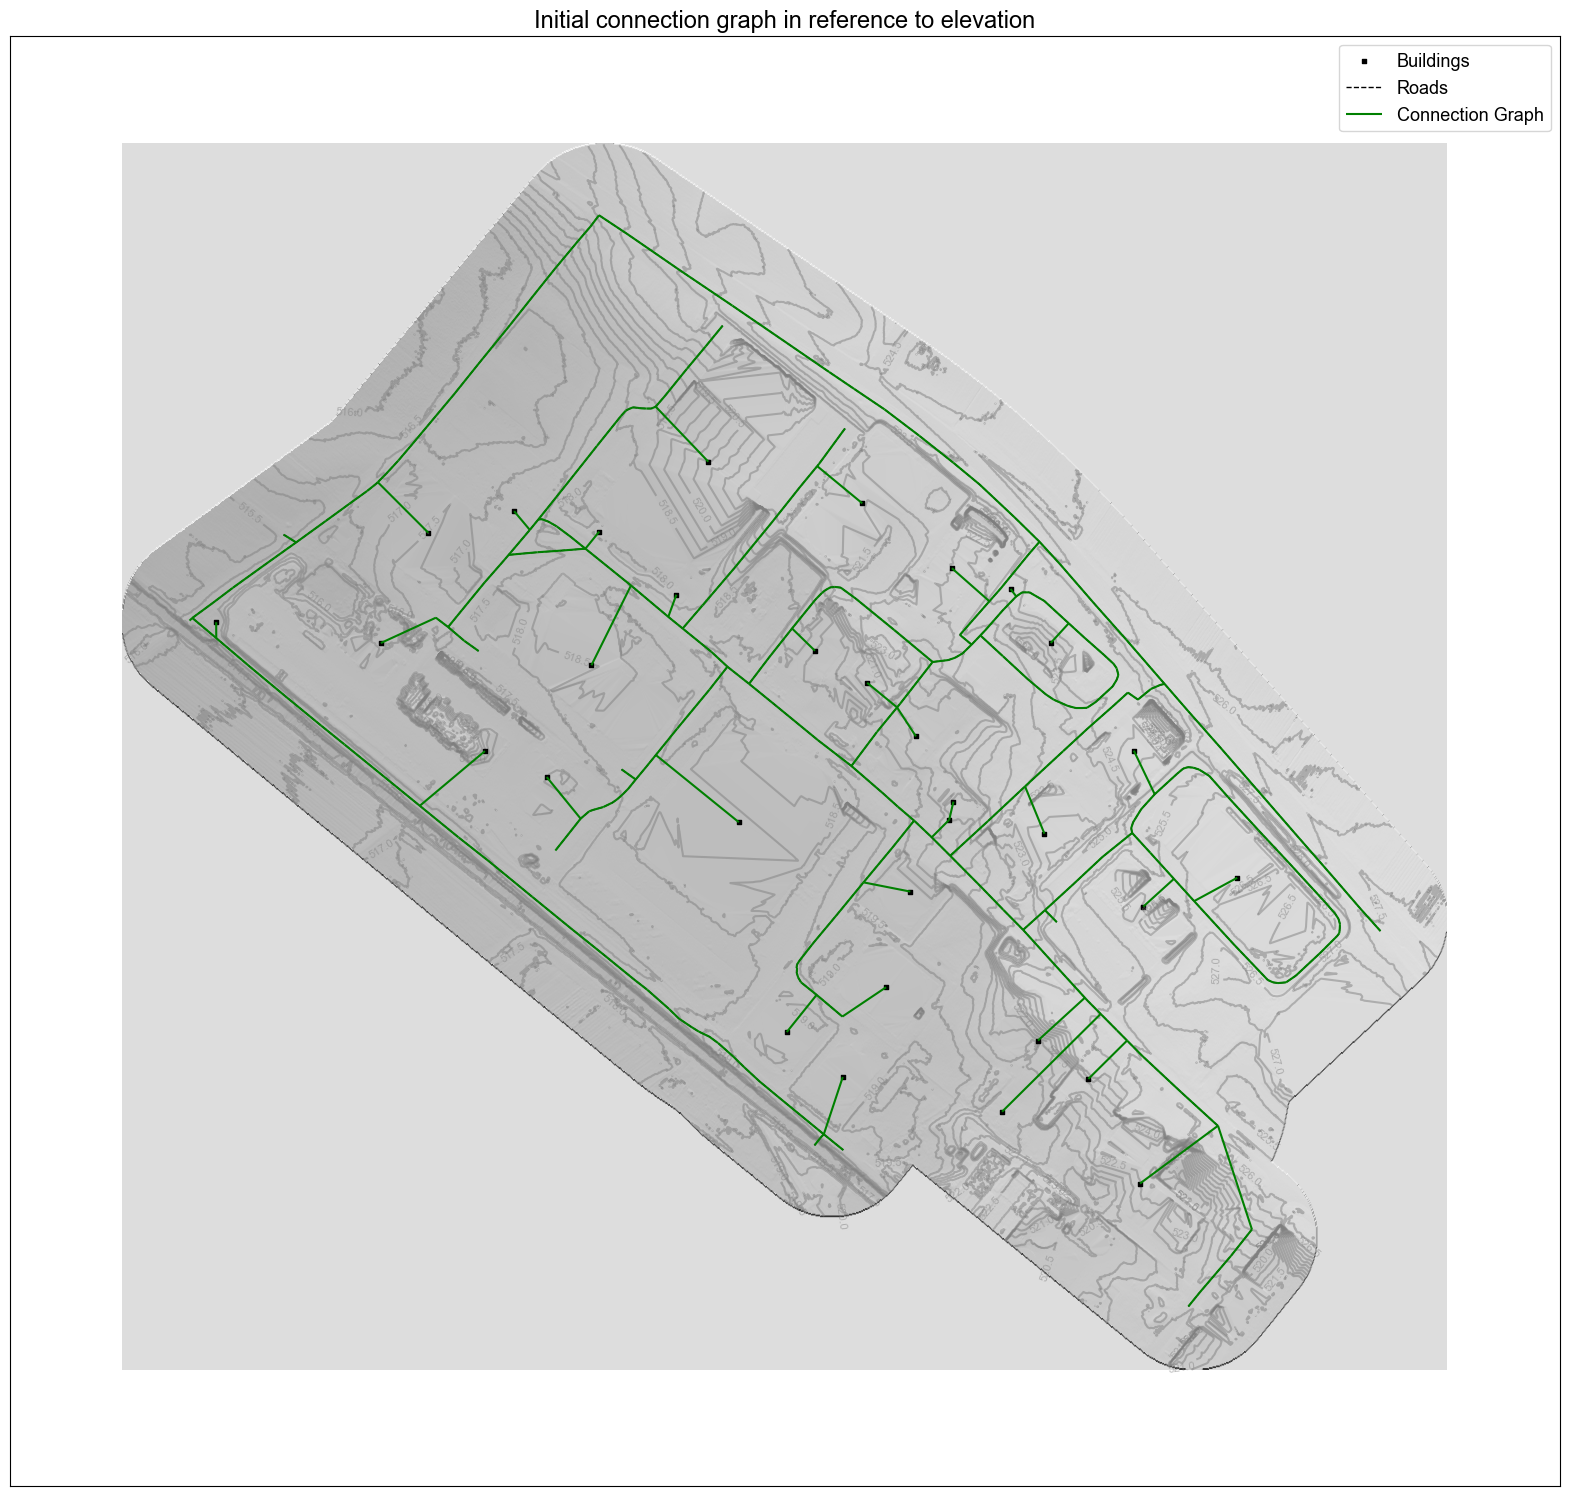

In [20]:
# Plot of the connection graph based on the initialisation of the input data. 
fig, ax = pysewer.plot_model_domain(
    test_model_domain,
    plot_connection_graph=custom_config.plotting.plot_connection_graph,
    hillshade=custom_config.plotting.hillshade,
)
ax.set_title("Initial connection graph in reference to elevation")

In [21]:
# preview the the buildings geoDataFrame
test_model_domain.buildings.get_gdf().head()


,OBJECTID,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,...,Art_Typ_de,Art_Typ_en,Shape_Length,Shape_Area,fid_2,id,geometry,nearest_point,distance,cluster
0,37,z5bed8746d67a002c,BBNachfuehrung[z5bed8185d67a00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z5bed8185d67a0000,ZH0200000172,993.005,...,Gebaeude,buildings,120.591741,897.661197,1,None,POINT (2698126.732 1249901.700),POINT (2698106.848849279 1249877.45684709),31.354116,9
1,84,z58caa8989bad00ca,BBNachfuehrung[z58ca9dcb9bad00,0,AV93,5,Gebaeude.Industrie_Gewerbe,z58ca9dcb9bad0000,ZH0200000172,987.003,...,Gebaeude,buildings,369.481248,7531.145419,1,None,POINT (2698068.846 1250043.637),POINT (2698022.609353691 1250081.07804802),59.495404,7
2,1438,z50ac8a910000170a,BBNachfuehrung[z50ac8a9100000d,0,AV93,7,Gebaeude.Nebengebaeude,z50ac8a9100000dcf,ZH0200000172,869F,...,Gebaeude,buildings,80.587071,188.869873,1,None,POINT (2698220.193 1250173.548),POINT (2698216.765248187 1250176.34405263),4.423395,0
3,1441,z50ac8a9100001707,BBNachfuehrung[z50ac8a9100000e,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000e1a,ZH0200000172,872F,...,Gebaeude,buildings,181.694953,1779.589934,1,None,POINT (2698187.510 1250185.116),POINT (2698208.415640934 1250166.696687056),27.862632,0
4,1504,z50ac8a91000016c1,BBNachfuehrung[z50ac8a9100000e,0,AV93,5,Gebaeude.Industrie_Gewerbe,z50ac8a9100000e6a,ZH0200000172,926F,...,Gebaeude,buildings,135.270188,1138.878007,1,None,POINT (2698095.528 1249926.740),POINT (2698112.656607027 1249947.069414506),26.583961,0


### Generate connection graph
This is the final step preprocessing where the initial graph is simplified to remove unnecessary nodes, converted to directed graph, checks for self-loops and removes them and enhances the nodes and edges by setting hydraulic elements of the network. 

In [22]:
# create the the graph conections
# this to be used for the routing algorithm
connection_graph = test_model_domain.generate_connection_graph()

300
105
Simplified graph: 300 to 94 nodes, 325 to 119 edges


In [23]:
# get the sinks within the area of interest. 
# verify that the sinks were addeded
test_model_domain.get_sinks()

[(2697762.89, 1250155.923)]

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


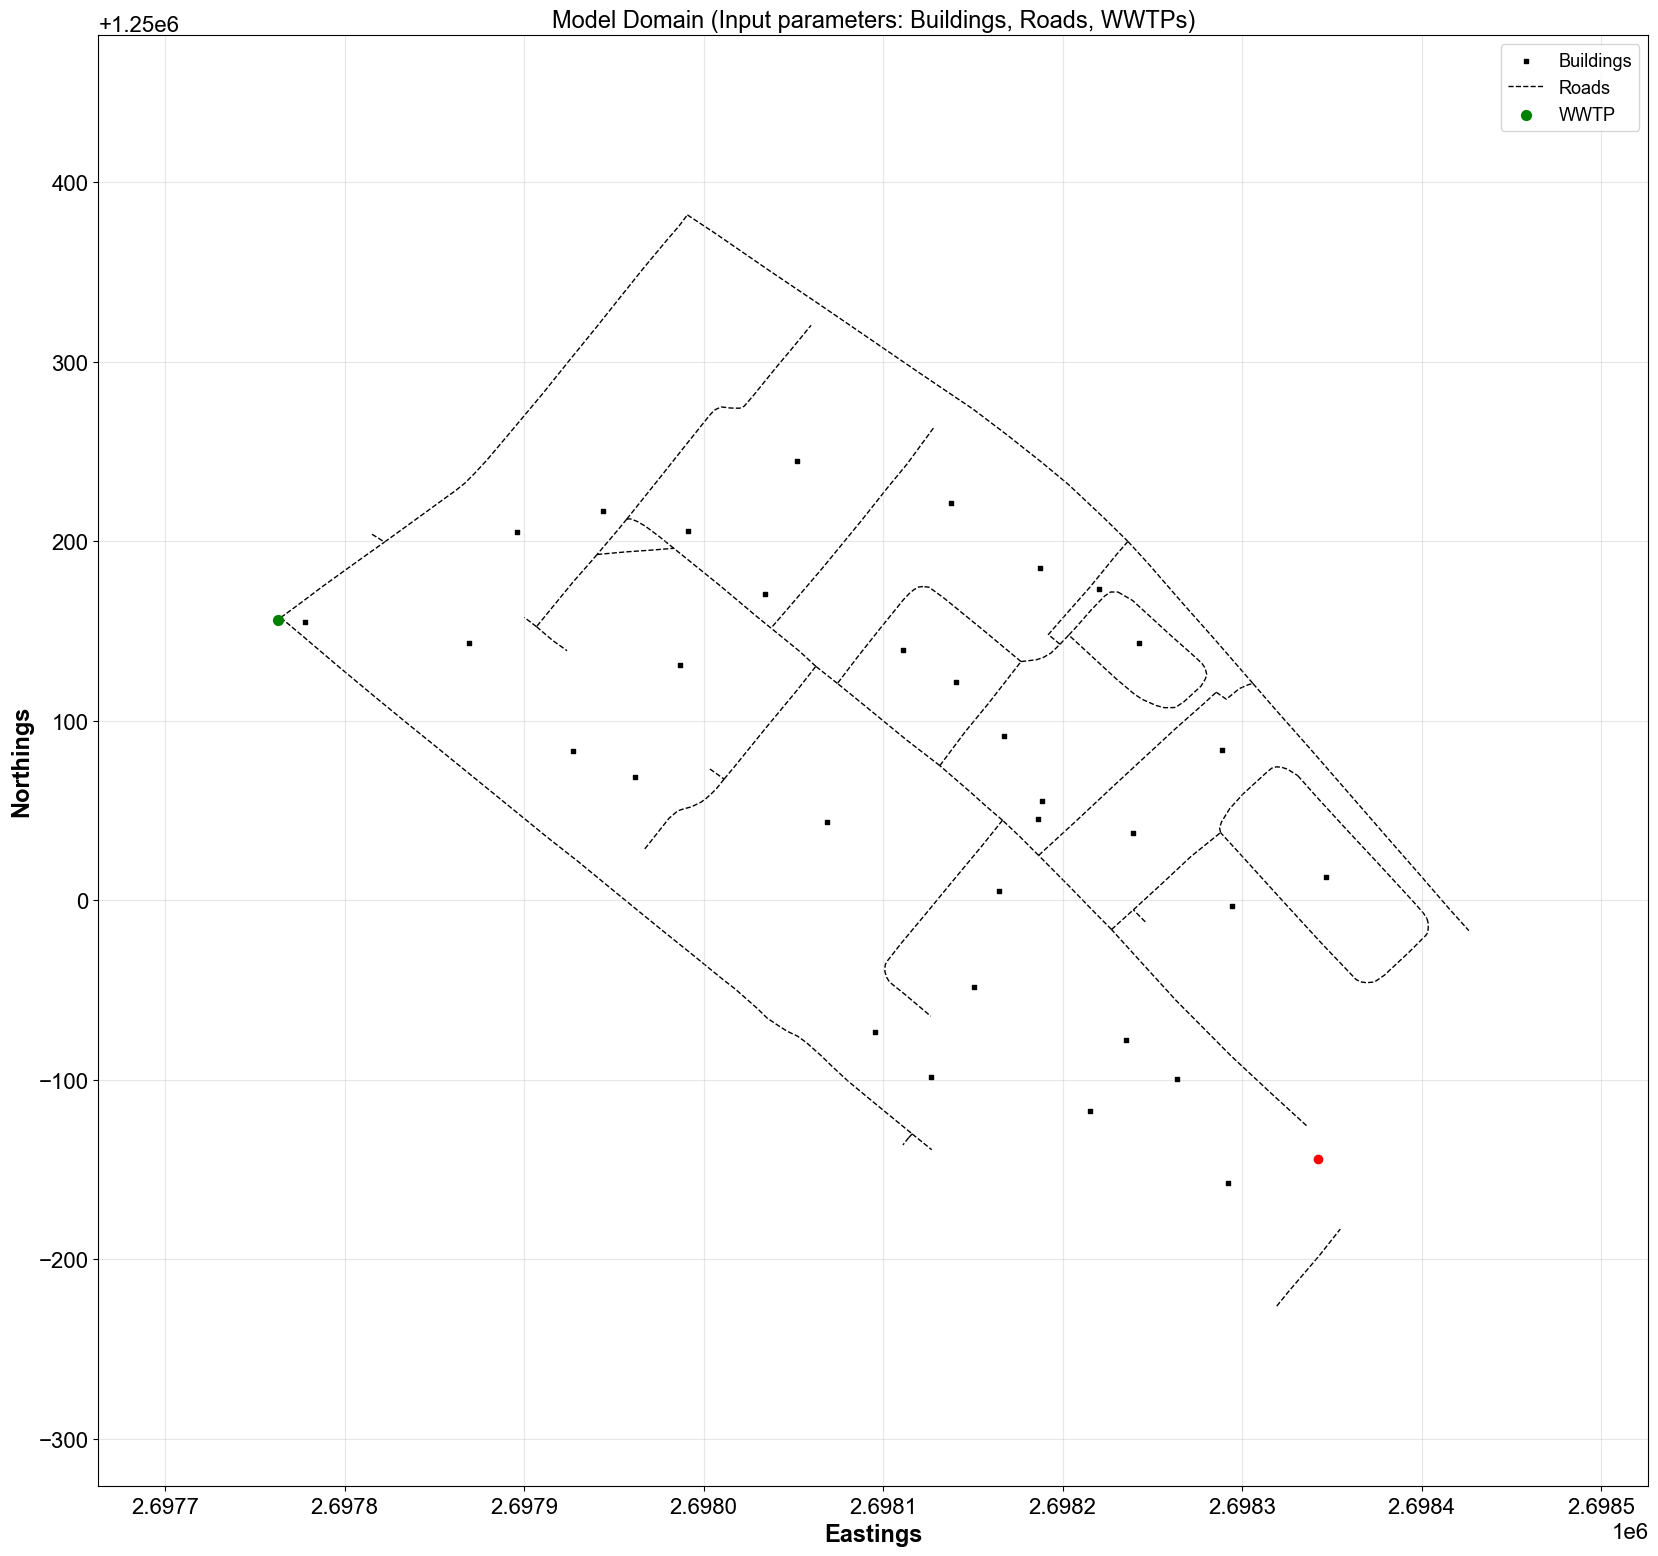

In [24]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sink=custom_config.plotting.plot_sink, 
)
ax.set_title("Model Domain (Input parameters: Buildings, Roads, WWTPs)")
# ax.set_xlim(689000, 691800)
# ax.set_ylim(2552500, 2558000)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
# add the point to the plot using the coordinates 
ax.plot(2698341.9587413343, 1249855.5749346223, "ro", label="missing_point")

## Routing

The routing solver implements the repeated shortest path heuristic (RSPH) algorithm to create a directed steiner tree. It iteratively construct a directed tree that connects a set of terminals (e.g., buildings) to a designated sink (e.g., a wastewater treatment plant).

In [25]:
# Generate optimal sewer layout 
layout = pysewer.rsph_tree(connection_graph, test_model_domain.get_sinks(), "building")

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


No pumping station in the sewer graph
Plotting sewer graph without pumping station


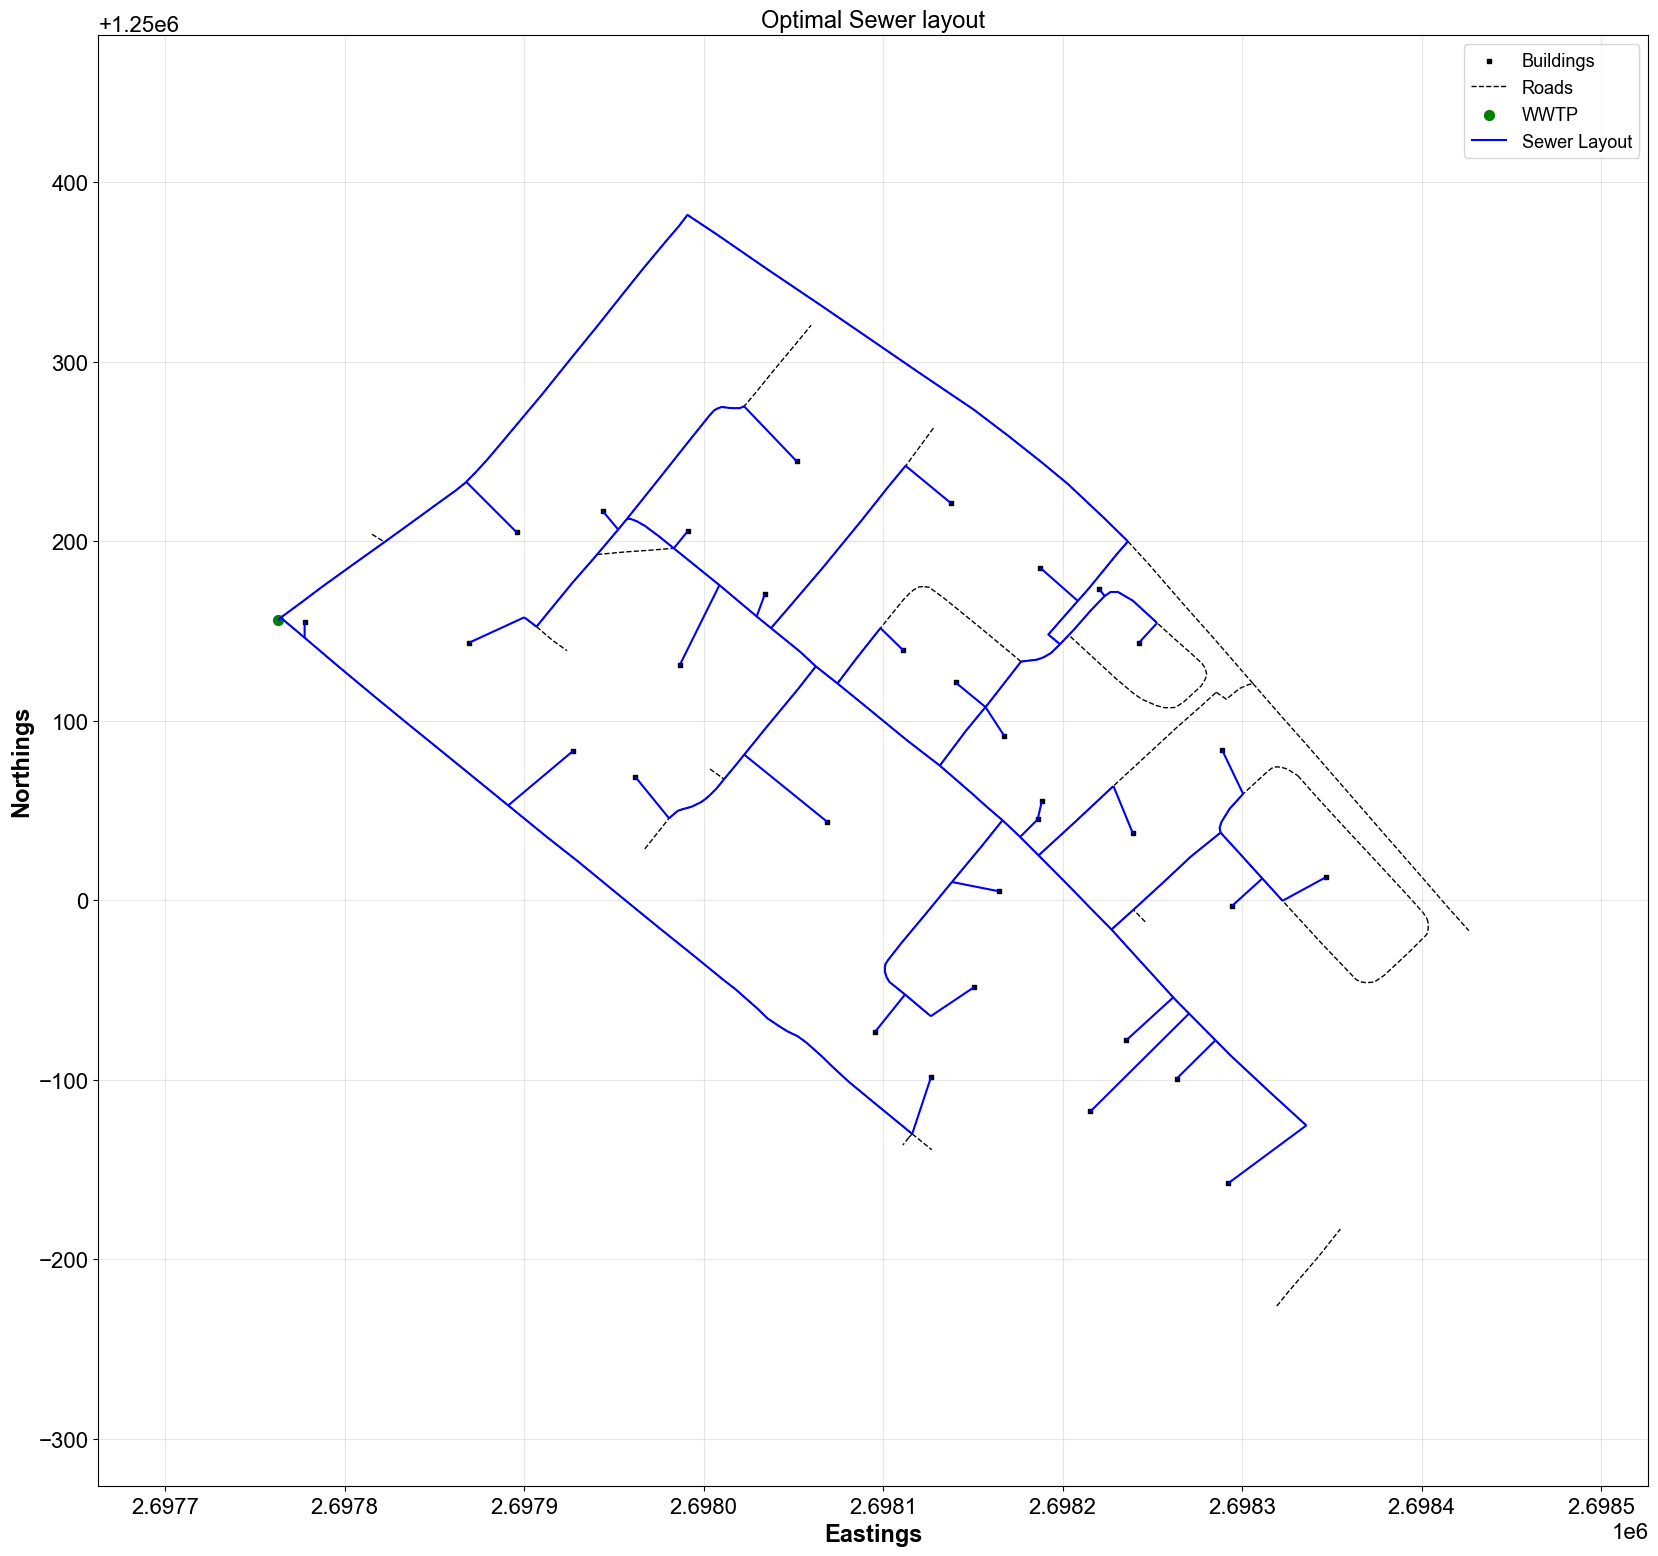

In [26]:
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=layout, plot_sink=True
)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.set_title("Optimal Sewer layout")
ax.grid(alpha=0.3)
plt.show()

## Hydraulic Design and Optimization

The purpose of this stage of generating the sewer network layout is to create a hydraulic-optimised layout. 
Here, the hydraulic-optimised layout is gravity-prioritised which limits the number of pumps in the final layout. 
Two key methods are employed here: 
1. Flow estimation, to determine the capacity needs of the sewer network and, 
2. Calculation of the hydraulic parameters, which covers the placement of pumps and sizing of the pipe diameters.


### Decision variables:
- pipe diameters: diameters selected based hydraulic capacity
- pipe slopes: determines whether pipe sections are gravity-prioritised or not. 
- pump penalty: a cost factor used to quantify the economic impacts of using pumps in the network.

### Constraints:
- hydraulic capacity: ensures that the flow rate in the pipes does not exceed the maximum capacity (peak flow)
- trench depth (tmin and tmax): ensures the pipes are deep enough but not too deep to avoid excessive costs.

The table below shows the hydraulic constraints and the parameters used in the optimization process.

| Constraint                      | Parameter                 | Value/Condition                      | Description                                                                        |
| ------------------------------- | ------------------------- | ------------------------------------ | ---------------------------------------------------------------------------------- |
| **Minimum Slope**               | `min_slope`               | -0.01                                | The minimum slope required for gravitational flow.                                 |
| **Maximum Trench Depth**        | `tmax`                    | 8 (m)                                | Maximum allowable trench depth to ensure cover and structural integrity.           |
| **Minimum Trench Depth**        | `tmin`                    | 0.25 (m)                             | Minimum trench depth to ensure adequate hydraulic flow.                            |
| **Inflow Trench Depth**         | `inflow_trench_depth`     | 0  (m)                               | Trench depth at the inflow point, used for initial calculations.                   |
| **Pipe Roughness**              | `roughness`               | 0.013 (s/m^{1/3})                    | Roughness coefficient of the pipes, affecting flow calculations.                   |
| **Pressurized Diameter**        | `pressurized_diameter`    | 0.2 (m)                              | Diameter of pipes when pressurized                                                 |
| **Available Diameters**         | `diameters`               | [0.1, 0.15, 0.2, 0.25, 0.3, 0.4] (m) | List of available pipe diameters for use in the network.                           |
| **Peak Factor**                 | `peak_factor`             | 2.3                                  | Multiplier to adjust calculated flow rates to account for peak times.              |
| **Inhabitants per Dwelling**    | `inhabitants_dwelling`    | 3                                    | Number of inhabitants per dwelling unit, used for wastewater generation estimates. |
| **Daily Wastewater per Person** | `daily_wastewater_person` | 0.2 (m³)                             | Daily wastewater output per person, essential for flow calculations.               |


### Objective Function:
Minimize the total cost of the sewer network, defined by the equation:

$$
Z = \sum_{i=1}^{n} (C_{\text{trench}, i} + C_{\text{pipe}, i}) + \sum_{j=1}^{m} C_{\text{pump}, j} + \lambda \cdot N_{\text{pumps}}
$$

Where:

- $ Z $ is the total cost of the sewer network.
- $ n $ is the number of pipe segments.
- $ m $ is the number of pumps.
- $C_{\text{trench}, i}$ is the trenching cost for pipe segment \( i \), calculated as $( c_{\text{trench}} \times d_i \times l_i)$.
- $C_{\text{pipe}, i}$ is the cost of the pipe for segment \( i \), calculated as $( c_{\text{pipe}} \times l_i)$.
- $C_{\text{pump}, j}$ is the base cost for installing and operating pump j.
- $ N_{\text{pumps}}$ is the total number of pumps
- $ \lambda $ is the pump penalty factor.

**Note:** The term "cost" in the objective function is used figuratively to represent a composite measure of various factors such as construction efforts, 
operational demands, and environmental impacts. It does not directly equate to monetary value but is a conceptual metric used to evaluate and minimize 
the overall resource expenditure of the sewer network design.


The location and the number of the pump is optimized through the setting of the pump penalty. By setting a high penalty, the design algorithm is encouraged 
to find solutions that rely on natural gravity flow and, therefore, avoid using pumps unless absolutely necessary. 
In addition, In order to decrease the number of pumps, the max. trench depth can be increased. However, this will result in overall higher costs associated with
the network. 
When a house is located deeper than the network itself, a private pump is set. The main difference between the private pump and pump station is,
that the private pump only deals with the water from that certain household (Average PE number per buildings), 
while pump station may be designed to convey the water from upstream network sections.

0
No pumping station in the sewer graph
Plotting sewer graph without pumping station


/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


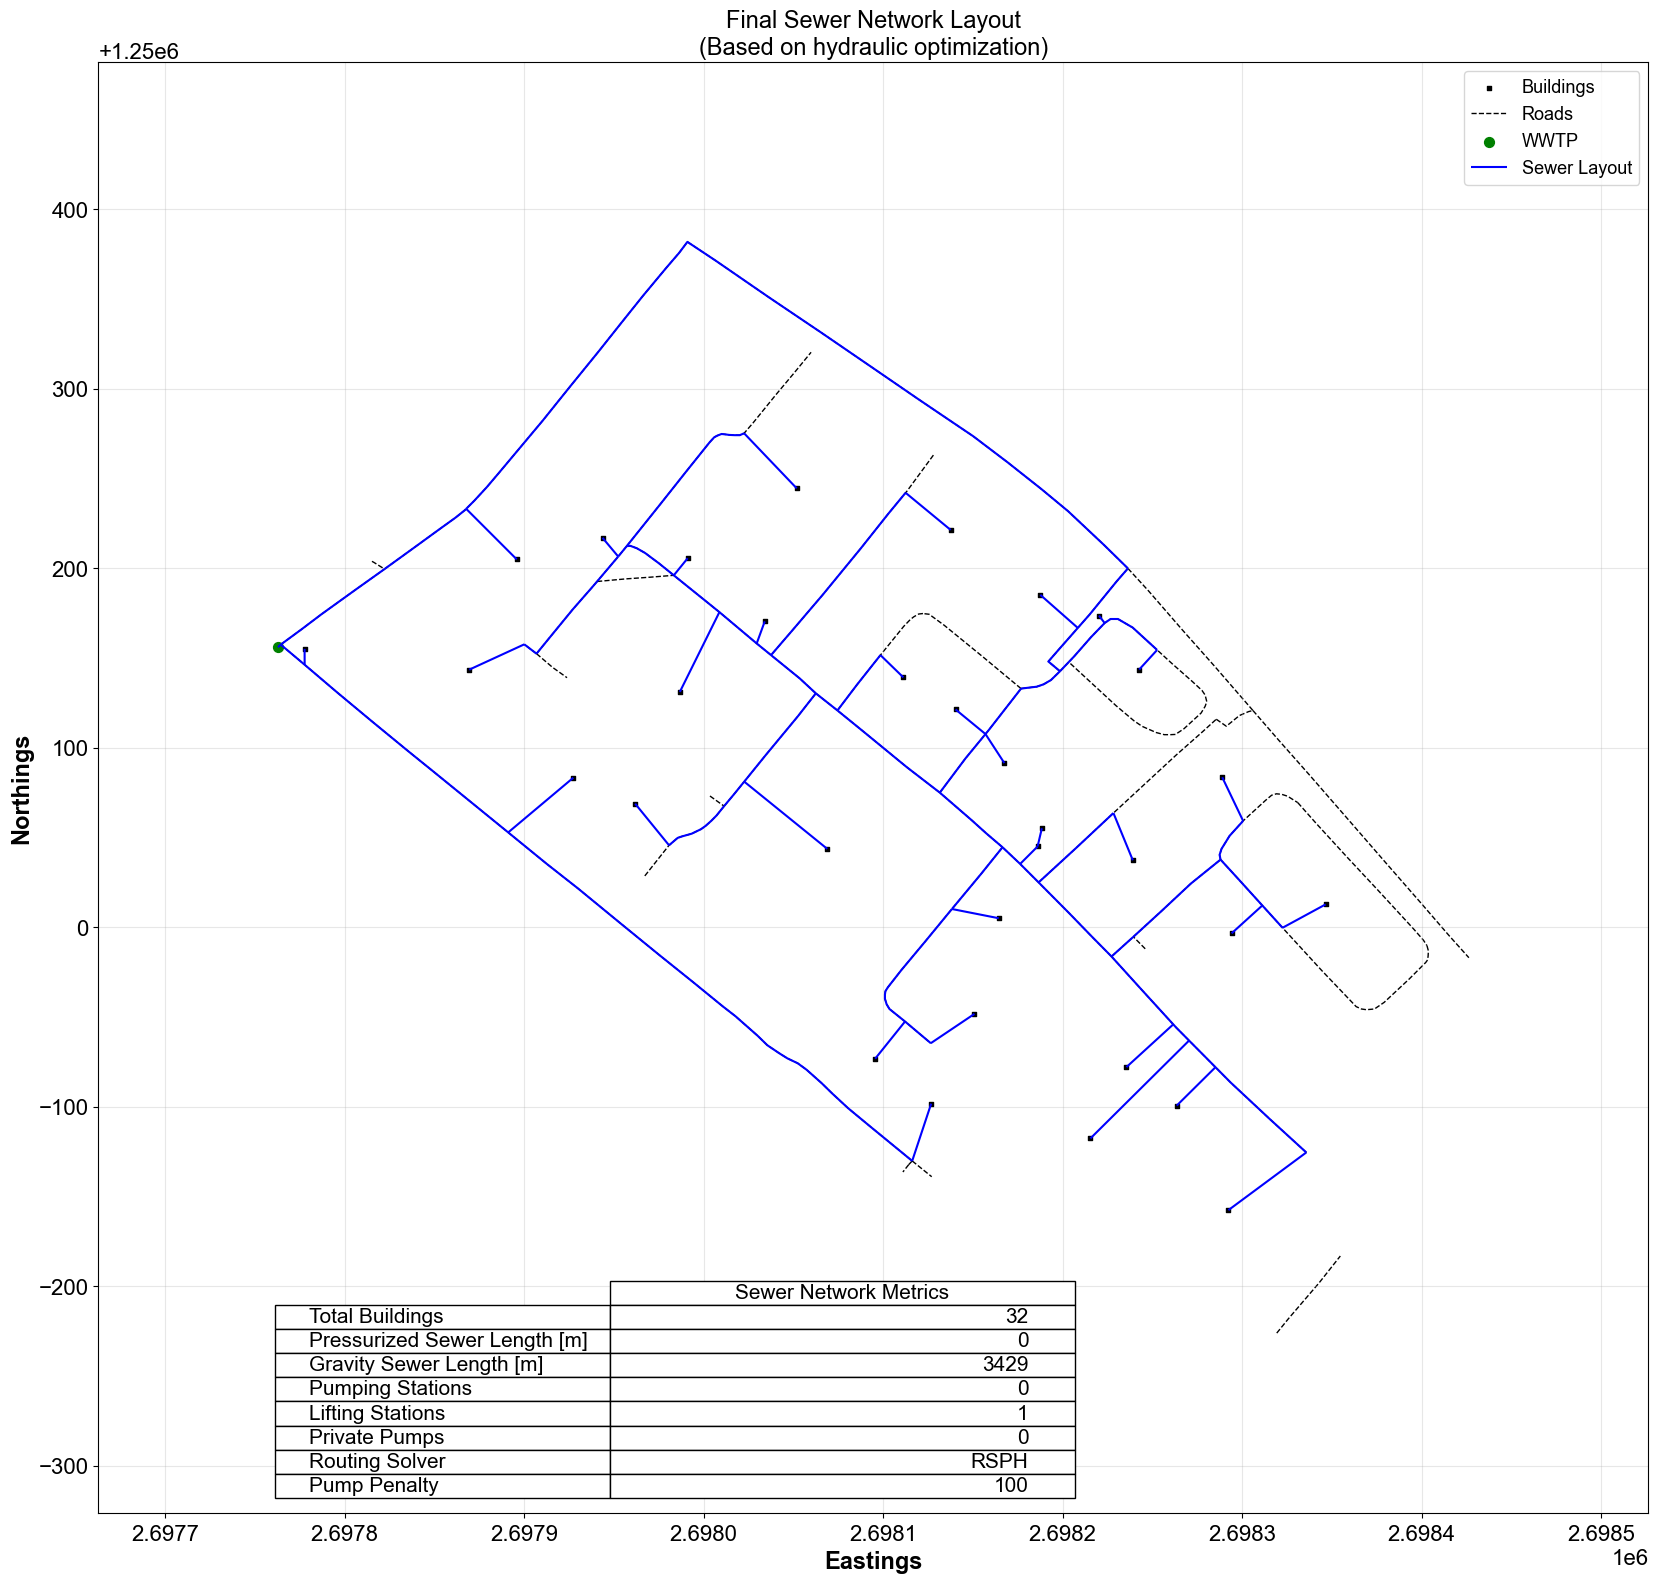

In [27]:
G = pysewer.estimate_peakflow(
    layout,
    inhabitants_dwelling=custom_config.optimization.inhabitants_dwelling,
    daily_wastewater_person=custom_config.optimization.daily_wastewater_person,
)
G = pysewer.calculate_hydraulic_parameters(
    layout,
    sinks=test_model_domain.get_sinks(),
    diameters=custom_config.optimization.diameters,
    pressurized_diameter=custom_config.optimization.pressurized_diameter,
    include_private_sewer=True,
    roughness=custom_config.optimization.roughness,
)
info = pysewer.get_sewer_info(G)
info["Routing Solver"] = "RSPH"
info["Pump Penalty"] = test_model_domain.pump_penalty
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=G, info_table=info, plot_sink=True
)
# ax.set_xlim(689000, 691800)
# ax.set_ylim(2552500, 2557800)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)

ax.set_title("Final Sewer Network Layout\n(Based on hydraulic optimization)")
plt.legend(loc="upper right")
plt.show()
# adjust the figure size 
# fig.set_size_inches(20, 20)
# fig.savefig("../data/figures/optimised_sewer_layout.svg", transparent=True, bbox_inches="tight")

### Peak flow estimation
The peak flow was estimated as the dry weather peak flow in accordance with (Tchobanoglous et al., 2003). 
The current peak flow is estimated as 2x hourly average flow (m3/s). The peak flow factor was selected as 2, however it can be changed by the user. 

Reference: Tchobanoglous, G., Burton, F. L., Stensel, H. D., & Metcalf & Eddy (Eds.). (2003). Wastewater engineering: Treatment and reuse (4th ed). McGraw-Hill.

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


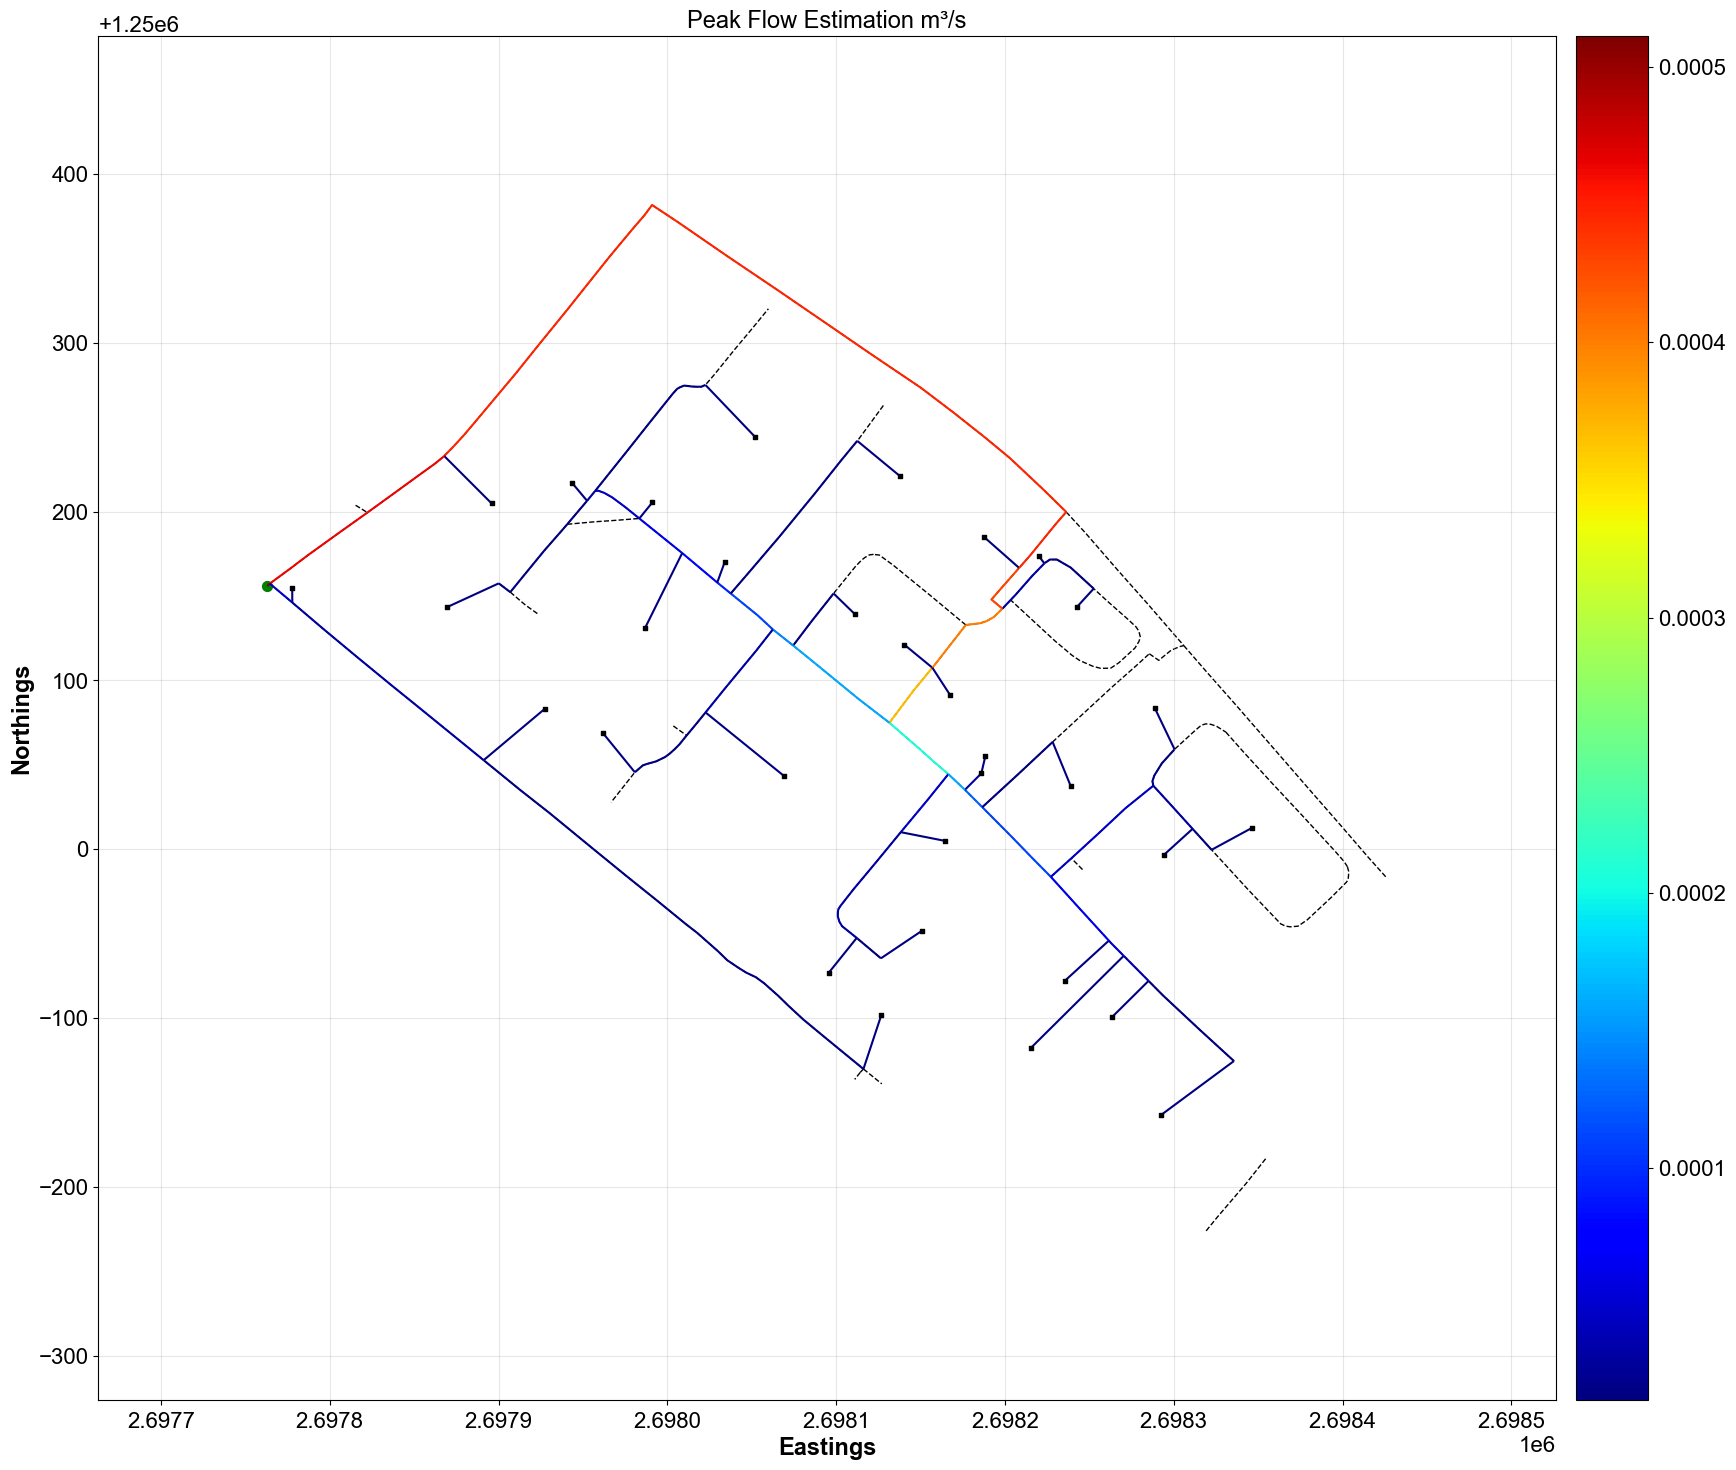

In [28]:
fig, ax = pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="peak_flow", title="Peak Flow Estimation m³/s", plot_sink=True
)

ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
plt.show()

### Pipe diameter
The pipe diameter was selected per section (between manholes) depending on the slope of the section and the cumulative number of PE 
(PE connected to that section plus the number of PE that are connected upstream) in accordance with (Tchobanoglous et al., 2003).

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


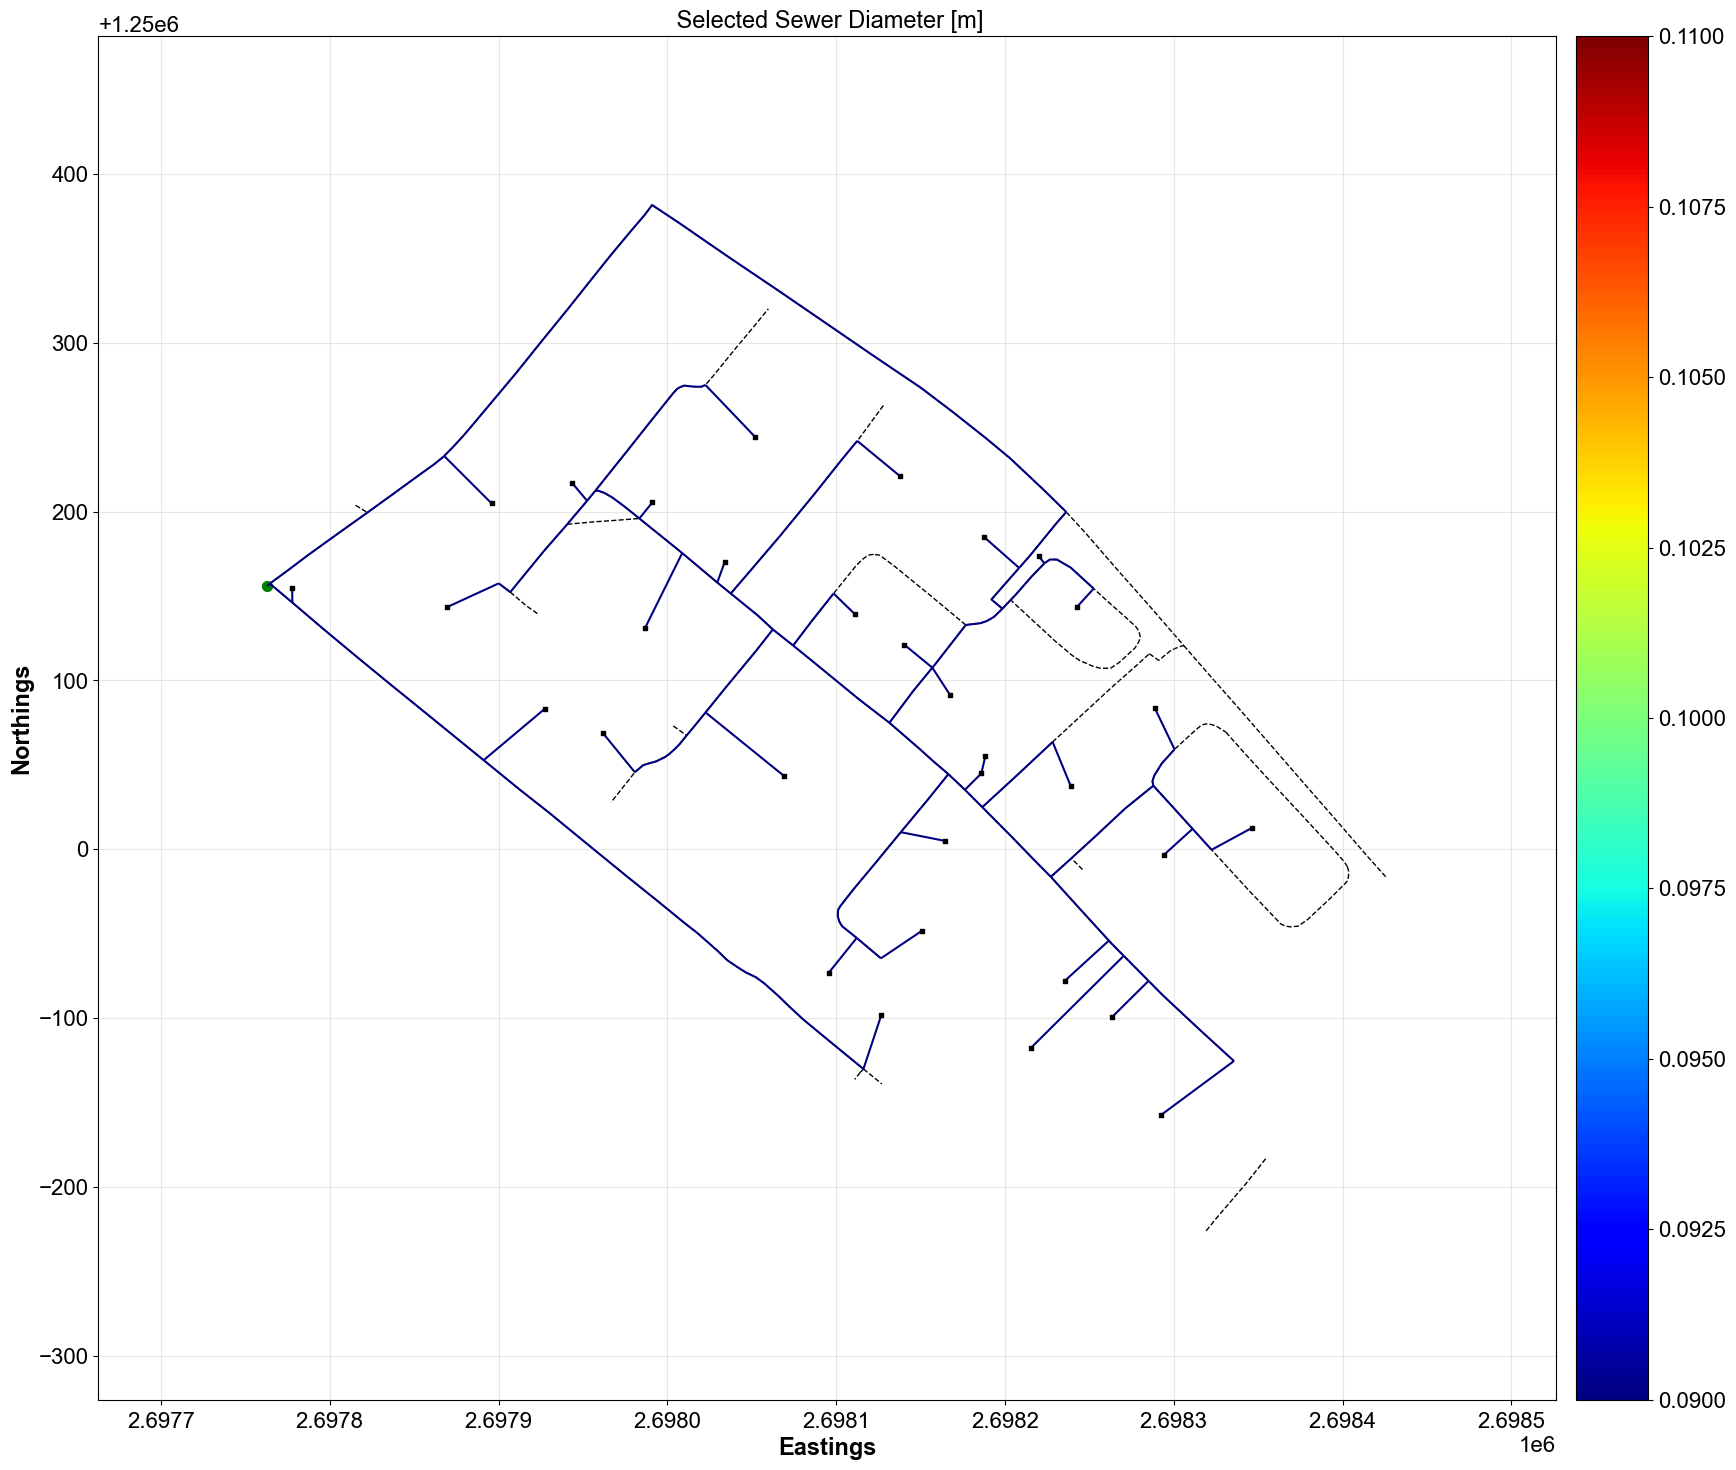

In [29]:
fig, ax = pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="diameter", title=" Selected Sewer Diameter [m]", plot_sink=True
)

ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
plt.show()

## Export Sewer Network

The sewer network is exported as a geopackage file using the pysewer.export module. Shapefiles and geoparquet files are also supported.


In [30]:
sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
pysewer.export_sewer_network(sewer_network_gdf, "sewer_network.gpkg")

Successfully exported sewer network to sewer_network.gpkg.


In [31]:
# check the file that was created 
import geopandas as gpd
sn_gdf = gpd.read_file("sewer_network.gpkg")
sn_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   distance                81 non-null     float64 
 1   profile                 81 non-null     object  
 2   needs_pump              81 non-null     object  
 3   weight                  81 non-null     float64 
 4   pressurized             81 non-null     object  
 5   trench_depth_profile    81 non-null     object  
 6   mean_td                 81 non-null     float64 
 7   diameter                81 non-null     float64 
 8   peak_flow               81 non-null     float64 
 9   edge_counter            81 non-null     int64   
 10  OBJECTID                5 non-null      float64 
 11  UUID                    81 non-null     object  
 12  DATUM_AENDERUNG         81 non-null     object  
 13  DATUM_ERSTELLUNG        81 non-null     object  
 14  ERSTELLUNG_JAHR     

In [32]:
sewer_network_gdf = pysewer.get_edge_gdf(G, detailed=True)
sewer_network_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                81 non-null     geometry
 1   distance                81 non-null     float64 
 2   profile                 81 non-null     object  
 3   needs_pump              81 non-null     bool    
 4   weight                  81 non-null     float64 
 5   pressurized             81 non-null     bool    
 6   trench_depth_profile    81 non-null     object  
 7   mean_td                 81 non-null     float64 
 8   diameter                81 non-null     float64 
 9   peak_flow               81 non-null     float64 
 10  edge_counter            81 non-null     int64   
 11  OBJECTID                5 non-null      float64 
 12  UUID                    5 non-null      object  
 13  DATUM_AENDERUNG         5 non-null      object  
 14  DATUM_ERSTELLUNG    

In [33]:
# try using geoparquet to save the geodataframe
sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)

/var/folders/ft/8qzbkr994y9gmhkqb5l97lsw0000gq/T/ipykernel_41096/1793822407.py:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  sewer_network_gdf.to_parquet("sewer_parq.parquet", index=False)


In [34]:
test_parq = gpd.read_parquet("sewer_parq.parquet")
test_parq.info()
test_parq

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                81 non-null     geometry
 1   distance                81 non-null     float64 
 2   profile                 81 non-null     object  
 3   needs_pump              81 non-null     bool    
 4   weight                  81 non-null     float64 
 5   pressurized             81 non-null     bool    
 6   trench_depth_profile    81 non-null     object  
 7   mean_td                 81 non-null     float64 
 8   diameter                81 non-null     float64 
 9   peak_flow               81 non-null     float64 
 10  edge_counter            81 non-null     int64   
 11  OBJECTID                5 non-null      float64 
 12  UUID                    5 non-null      object  
 13  DATUM_AENDERUNG         5 non-null      object  
 14  DATUM_ERSTELLUNG    

,geometry,distance,profile,needs_pump,weight,pressurized,trench_depth_profile,mean_td,diameter,peak_flow,...,RICHTUNGSGETRENNT,BELAGSART,KREISEL,EIGENTUEMER,VERKEHRSBEDEUTUNG,NAME,TLM_STRASSEN_NAME_UUID,Shape_Length,id,private_sewer
0,"LINESTRING (2698287.914 1250037.652, 2698271.3...",64.885060,"[[0.0, 525.06], [10.0, 524.89], [20.0, 524.82]...",False,64.885060,False,"[[0.0, 524.4811072656904], [10.0, 524.38110726...",0.559031,0.1,0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,"LINESTRING (2698300.482 1250059.216, 2698292.9...",25.965451,"[[0.0, 525.14], [10.0, 525.11], [20.0, 525.08]...",False,25.965451,False,"[[0.0, 524.740761773704], [10.0, 524.640761773...",0.496652,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,"LINESTRING (2698322.442 1249999.685, 2698311.1...",16.759188,"[[0.0, 526.15], [10.0, 525.92], [16.7591878813...",False,16.759188,False,"[[0.0, 525.9], [10.0, 525.67], [16.75918788130...",0.250000,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,"LINESTRING (2697983.381 1250195.997, 2698008.7...",32.640649,"[[0.0, 518.19], [10.0, 518.29], [20.0, 518.38]...",False,32.640649,False,"[[0.0, 515.5603323638653], [10.0, 515.46033236...",2.998949,0.1,0.000064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,"LINESTRING (2697957.187 1250212.274, 2697959.1...",31.407372,"[[0.0, 517.94], [10.0, 518.03], [20.0, 518.09]...",False,31.407372,False,"[[0.0, 515.8744060794339], [10.0, 515.77440607...",2.392409,0.1,0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,"LINESTRING (2698270.378 1249936.859, 2698263.1...",12.603922,"[[0.0, 525.03], [10.0, 524.8], [12.60392188519...",False,12.603922,False,"[[0.0, 518.6172595031744], [10.0, 518.51725950...",6.311420,0.1,0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
77,"LINESTRING (2698235.469 1249922.054, 2698261.5...",35.340198,"[[0.0, 520.95], [10.0, 524.15], [20.0, 524.85]...",False,35.340198,False,"[[0.0, 520.7], [10.0, 520.6], [20.0, 520.5], [...",3.384680,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
78,"LINESTRING (2698261.574 1249945.876, 2698243.8...",51.096042,"[[0.0, 524.73], [10.0, 524.46], [20.0, 524.18]...",False,51.096042,False,"[[0.0, 518.4912202843225], [10.0, 518.39122028...",5.688917,0.1,0.000064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
79,"LINESTRING (2698263.508 1249900.636, 2698285.0...",30.383032,"[[0.0, 523.98], [10.0, 524.84], [20.0, 525.14]...",False,30.383032,False,"[[0.0, 523.73], [10.0, 523.63], [20.0, 523.53]...",1.398766,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [35]:
sewer_network_gdf

,geometry,distance,profile,needs_pump,weight,pressurized,trench_depth_profile,mean_td,diameter,peak_flow,...,RICHTUNGSGETRENNT,BELAGSART,KREISEL,EIGENTUEMER,VERKEHRSBEDEUTUNG,NAME,TLM_STRASSEN_NAME_UUID,Shape_Length,id,private_sewer
0,"LINESTRING (2698287.914 1250037.652, 2698271.3...",64.885060,"[(0.0, 525.06), (10.0, 524.89), (20.0, 524.82)...",False,64.885060,False,"[(0.0, 524.4811072656904), (10.0, 524.38110726...",0.559031,0.1,0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"LINESTRING (2698300.482 1250059.216, 2698292.9...",25.965451,"[(0.0, 525.14), (10.0, 525.11), (20.0, 525.08)...",False,25.965451,False,"[(0.0, 524.740761773704), (10.0, 524.640761773...",0.496652,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"LINESTRING (2698322.442 1249999.685, 2698311.1...",16.759188,"[(0.0, 526.15), (10.0, 525.92), (16.7591878813...",False,16.759188,False,"[(0.0, 525.9), (10.0, 525.67), (16.75918788130...",0.250000,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"LINESTRING (2697983.381 1250195.997, 2698008.7...",32.640649,"[(0.0, 518.19), (10.0, 518.29), (20.0, 518.38)...",False,32.640649,False,"[(0.0, 515.5603323638653), (10.0, 515.46033236...",2.998949,0.1,0.000064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"LINESTRING (2697957.187 1250212.274, 2697959.1...",31.407372,"[(0.0, 517.94), (10.0, 518.03), (20.0, 518.09)...",False,31.407372,False,"[(0.0, 515.8744060794339), (10.0, 515.77440607...",2.392409,0.1,0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,"LINESTRING (2698270.378 1249936.859, 2698263.1...",12.603922,"[(0.0, 525.03), (10.0, 524.8), (12.60392188519...",False,12.603922,False,"[(0.0, 518.6172595031744), (10.0, 518.51725950...",6.311420,0.1,0.000048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,"LINESTRING (2698235.469 1249922.054, 2698261.5...",35.340198,"[(0.0, 520.95), (10.0, 524.15), (20.0, 524.85)...",False,35.340198,False,"[(0.0, 520.7), (10.0, 520.6), (20.0, 520.5), (...",3.384680,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
78,"LINESTRING (2698261.574 1249945.876, 2698243.8...",51.096042,"[(0.0, 524.73), (10.0, 524.46), (20.0, 524.18)...",False,51.096042,False,"[(0.0, 518.4912202843225), (10.0, 518.39122028...",5.688917,0.1,0.000064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,"LINESTRING (2698263.508 1249900.636, 2698285.0...",30.383032,"[(0.0, 523.98), (10.0, 524.84), (20.0, 525.14)...",False,30.383032,False,"[(0.0, 523.73), (10.0, 523.63), (20.0, 523.53)...",1.398766,0.1,0.000016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


# combuine sewers 

In [36]:
G = pysewer.estimate_peakflow(
    layout,
    inhabitants_dwelling=custom_config.optimization.inhabitants_dwelling,
    daily_wastewater_person=custom_config.optimization.daily_wastewater_person,
)
G = pysewer.calculate_hydraulic_parameters(
    layout,
    sinks=test_model_domain.get_sinks(),
    diameters=custom_config.optimization.diameters,
    pressurized_diameter=custom_config.optimization.pressurized_diameter,
    include_private_sewer=True,
    roughness=custom_config.optimization.roughness,
    combined_sewer_factor = 8
)
info = pysewer.get_sewer_info(G)
info["Routing Solver"] = "RSPH"
info["Pump Penalty"] = test_model_domain.pump_penalty
fig, ax = pysewer.plot_model_domain(
    test_model_domain, plot_sewer=True, sewer_graph=G, info_table=info, plot_sink=True
)
# ax.set_xlim(689000, 691800)
# ax.set_ylim(2552500, 2557800)
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)

ax.set_title("Final Sewer Network Layout\n(Based on hydraulic optimization)")
plt.legend(loc="upper right")
plt.show()
# adjust the figure size 
# fig.set_size_inches(20, 20)
# fig.savefig("../data/figures/optimised_sewer_layout.svg", transparent=True, bbox_inches="tight")

TypeError: calculate_hydraulic_parameters() got an unexpected keyword argument 'combined_sewer_factor'

In [ ]:
fig, ax = pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="diameter", title=" Selected Sewer Diameter [m]", plot_sink=True
)

ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
plt.show()

In [ ]:
fig, ax = pysewer.plot_sewer_attributes(
    test_model_domain, G, attribute="peak_flow", title="Peak Flow Estimation m³/s", plot_sink=True
)

ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.grid(alpha=0.3)
plt.show()